# DengAI Multivariate CNN LAG 31

14.94

## 1. Preparation

Libraries:

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
import seaborn as sns
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import load_model

Load Data:

In [2]:
train_raw = pd.read_csv("../data/dengue_features_train.csv")
train_labels = pd.read_csv("../data/dengue_labels_train.csv")
test_raw = pd.read_csv("../data/dengue_features_test.csv")

Train/Test for San Juan

In [3]:
train_sj = pd.concat(
    [train_raw[train_raw.city=="sj"], train_labels.loc[train_labels.city=="sj", "total_cases"]], 
    axis=1
).reset_index(drop=True)
test_sj = test_raw[test_raw.city=="sj"].reset_index(drop=True)

Train/Test for Iquitos

In [4]:
train_iq = pd.concat(
    [train_raw[train_raw.city=="iq"], train_labels.loc[train_labels.city=="iq", "total_cases"]], 
    axis=1
).reset_index(drop=True)
test_iq = test_raw[test_raw.city=="iq"].reset_index(drop=True)

# 2. Interpolate NA

In [5]:
train_sj.interpolate(method='linear', limit_direction='forward', inplace=True)
test_sj.interpolate(method='linear', limit_direction='forward', inplace=True)
train_iq.interpolate(method='linear', limit_direction='forward',inplace=True)
test_iq.interpolate(method='linear', limit_direction='forward', inplace=True)

# 3. Prepare Lag Data San Juan

In [6]:
variables=['precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'weekofyear']

In [239]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_sj[variables])
train_sj[variables] = scaler.transform(train_sj[variables])

In [240]:
def ts_lag(data, max_lag):
    df = data.copy() # Avoids overwriting of the orginal df
    c = pd.DataFrame() # Empty dataframe
    for name in df.columns:
        for i in range(max_lag,0,-1): # Count backwards
            c[name+str(-i)]=df[name].shift(i) # Lag
        c[name] = df[name]
    
    c = c.dropna().reset_index(drop=True)
    # Reshape : number of observations, variables, lags +1 to include t
    c = c.values.reshape(len(c),len(data.columns),max_lag+1) 
    
    # Above code reshape in horizontal, we need each column = variable -> Transpose
    l = [] 
    for i in range(0,len(c)):
        l.append(c[i].transpose())
    
    return np.array(l)

X = ts_lag(train_sj[variables], 31)
y = train_sj.total_cases.values[31:]

In [241]:
X.shape

(905, 32, 17)

# Train Model

In [243]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(32, 17)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer="adam", loss='mae')

In [244]:
model.fit(X, y,epochs=200, verbose=0)

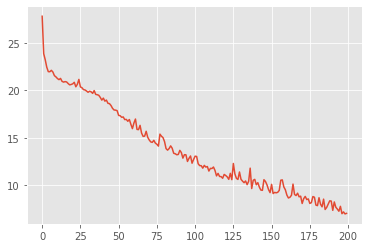

In [245]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Prepare Test for predictions

In [246]:
test_sj[variables]=scaler.transform(test_sj[variables])

In [247]:
def ts_lag_test(train_original, test, max_lag):
    train = train_original.copy() # To avoid inplace errors.
    test = test.copy()
    c = pd.DataFrame() # Empty dataset to append the new lag variables in order.
    for name in test.columns: # Name of the variables.
        for i in range(max_lag,0,-1): # We want a sorted sequence t-2,t-1,t So we first compute de max lag and then go decreasing. 0 is not included.
            c[name+str(-i)]=test[name].shift(i)
            c[name+str(-i)][0:i] = train[name][len(train)-i:len(train)] # Replace the NA value with the last observation of the complete train.
        c[name] = test[name]
        
        
    c = c.dropna().reset_index(drop=True)
    # Reshape : number of observations, variables, lags +1 to include t
    c = c.values.reshape(len(c),len(train_original.columns),max_lag+1) 
    
    # Above code reshape in horizontal, we need each column = variable -> Transpose
    l = [] 
    for i in range(0,len(c)):
        l.append(c[i].transpose())
    
    return np.array(l)

X_test = ts_lag_test(train_sj[variables],test_sj[variables],31)

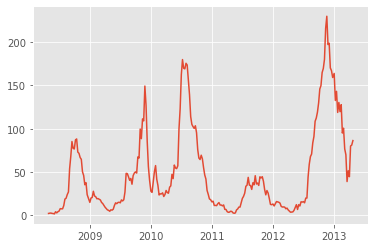

In [248]:
yhat_sj=model.predict(X_test)
yhat_sj=pd.DataFrame(yhat_sj, columns=["Pred"]).\
    set_index(
        test_sj.week_start_date.\
              astype('datetime64[ns]'))
fig=plt.plot(yhat_sj)

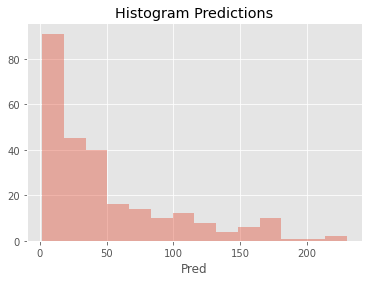

In [249]:
fig=sns.distplot(yhat_sj.Pred, kde=False)
fig=plt.title("Histogram Predictions")

In [250]:
np.mean(yhat_sj)

Pred    49.376953
dtype: float32

In [251]:
yhat_sj=np.where(yhat_sj<0,0,yhat_sj).astype(int)

# Iquitos

In [252]:
scaler.fit(train_iq[variables])
train_iq[variables] = scaler.transform(train_iq[variables])

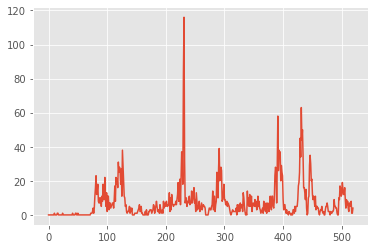

In [253]:
train_iq.total_cases.plot()

In [254]:
X = ts_lag(train_iq[variables], 31)
y = train_iq.total_cases.values[31:]

In [255]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(32, 17)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer="adam", loss='mae')

In [256]:
model.fit(X, y,epochs=100, verbose=0)

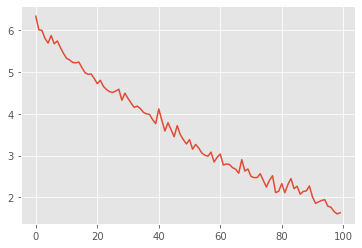

In [257]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [258]:
test_iq[variables] = scaler.transform(test_iq[variables])

In [259]:
X_test = ts_lag_test(train_iq[variables],test_iq[variables],31)

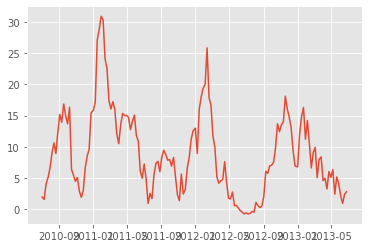

In [260]:
yhat_iq=model.predict(X_test)
yhat_iq=pd.DataFrame(yhat_iq, columns=["Pred"]).\
    set_index(
        test_iq.week_start_date.\
              astype('datetime64[ns]'))
fig=plt.plot(yhat_iq)

In [261]:
len(yhat_iq)

156

In [262]:
yhat_iq=np.where(yhat_iq<0,0,yhat_iq).astype(int)

In [263]:
sub = pd.read_csv("../Python/uploads_data/lstm_uni.csv")


In [264]:
sub.loc[sub.city=="sj","total_cases"] = yhat_sj
sub.loc[sub.city=="iq","total_cases"] = yhat_iq

In [265]:
np.mean(train_iq.total_cases)

7.565384615384615

In [266]:
np.mean(sub.loc[sub.city=="iq", "total_cases"])

8.467948717948717

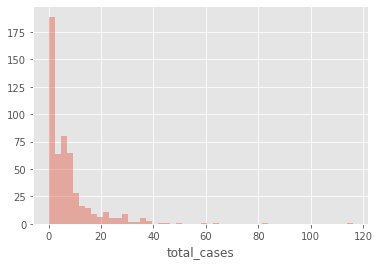

In [267]:
sns.distplot(train_iq.total_cases,kde=False)

In [268]:
len(train_iq)

520

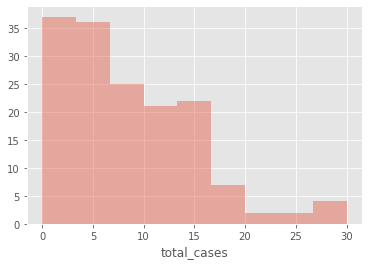

In [269]:
sns.distplot(sub.loc[sub.city=="iq", "total_cases"],kde=False)

In [270]:
sub.to_csv("lstm_mul_g.csv", index=False)

In [271]:
sub

,city,year,weekofyear,total_cases
0,sj,2008,18,2
1,sj,2008,19,2
2,sj,2008,20,2
3,sj,2008,21,2
4,sj,2008,22,2
...,...,...,...,...
411,iq,2013,22,4
412,iq,2013,23,2
413,iq,2013,24,0
414,iq,2013,25,2


![](uploads/forteen.png)